In [1]:
import time
import datetime
import torch
import random
import numpy as np
import pandas as pd
import math
from sklearn.preprocessing import scale

In [2]:
# для воспроизводимости эксперимента:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [3]:
timesample = 0.004
start_time = 1.0
end_time = 2.0
n_receivers = 80
n_timesamples = int((end_time - start_time)/timesample)

data = np.empty([1,2,n_receivers,n_timesamples])

In [4]:
n_models = 1100

for i in range(n_models):
    if (i+1) % 100 == 0:
        print(i+1,'/',n_models)
    data_Z = pd.read_csv('csv_models_1frac_Z\\model_{}.csv'.format(i+1))
    model_gather_Z = np.array(data_Z[data_Z.columns[int(start_time/timesample):int(end_time/timesample)]])
    
    data_X = pd.read_csv('csv_models_1frac_X\\model_{}.csv'.format(i+1))
    model_gather_X = np.array(data_X[data_X.columns[int(start_time/timesample):int(end_time/timesample)]])
    
    model_gather = np.vstack(([model_gather_Z],[model_gather_X]))
    model_gather = np.reshape(model_gather,(1,2,n_receivers,n_timesamples))
    
    data = np.vstack((data,model_gather))
    
data = data[1:]

100 / 1100
200 / 1100
300 / 1100
400 / 1100
500 / 1100
600 / 1100
700 / 1100
800 / 1100
900 / 1100
1000 / 1100
1100 / 1100


In [ ]:
print(data.shape)

In [5]:
# центрирование и нормализация данных
for i in range(n_models):
    for j in range(2):
        data[i,j] = scale(data[i,j], axis=1)

In [6]:
frac_params = pd.read_csv('frac_params_1frac_sys.csv')
frac_params['dt'] *= 2.5
frac_params['e'] *= 6.3
frac_params = np.array(frac_params[['dn','dt','e']])

In [7]:
X_train = torch.Tensor(data[:800])
X_validation = torch.Tensor(data[800:1100])

Y_train = torch.Tensor(frac_params[:800])
Y_validation = torch.Tensor(frac_params[800:1100])

In [8]:
class FracAnisotropyNet(torch.nn.Module):
    def __init__(self,n1,n2,n3):
        super(FracAnisotropyNet,self).__init__()
        
        self.conv1 = torch.nn.Conv2d(in_channels=2, out_channels=n1, kernel_size=(2,4), padding=0, stride=2)
        self.ac1 = torch.nn.ReLU()
        self.bn1 = torch.nn.BatchNorm2d(num_features=n1)
        #self.do1 = torch.nn.Dropout(p=prob)
        #self.pool1 = torch.nn.MaxPool1d(kernel_size=2, stride=2)
        
        self.conv2 = torch.nn.Conv2d(in_channels=n1, out_channels=n2, kernel_size=3, padding=0, stride=2)
        self.ac2 = torch.nn.ReLU()
        self.bn2 = torch.nn.BatchNorm2d(num_features=n2)
        
        self.conv3 = torch.nn.Conv2d(in_channels=n2, out_channels=n3, kernel_size=(2,3), padding=1, stride=(1,2))
        self.ac3 = torch.nn.ReLU()
        self.bn3 = torch.nn.BatchNorm2d(num_features=n3)
        self.pool3 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = torch.nn.Linear(10*15*n3,50)
        self.ac1_ = torch.nn.Tanh()
        #self.bn1_ = torch.nn.BatchNorm1d(num_features=80)
        self.fc2 = torch.nn.Linear(50,20)
        self.ac2_ = torch.nn.Tanh()
        
        self.out = torch.nn.Linear(20,3) 
        
    def forward(self,x):
        #print(x.size(0),' x ', x.size(1),' x ', x.size(2),' x ', x.size(3))
        
        x = self.conv1(x)
        x = self.ac1(x)
        x = self.bn1(x)
        #print(x.size(0),' x ', x.size(1),' x ', x.size(2),' x ', x.size(3))
            
        x = self.conv2(x)
        x = self.ac2(x)
        x = self.bn2(x)
        #print(x.size(0),' x ', x.size(1),' x ', x.size(2),' x ', x.size(3))
            
        x = self.conv3(x)
        x = self.ac3(x)
        x = self.bn3(x)
        #print(x.size(0),' x ', x.size(1),' x ', x.size(2),' x ', x.size(3))
        x = self.pool3(x)
        #print(x.size(0),' x ', x.size(1),' x ', x.size(2),' x ', x.size(3))
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        
        #print(x.size(1))
        
        x = self.fc1(x)
        x = self.ac1_(x)
        #print(x.size(1))
        #x = self.bn1_(x)
        x = self.fc2(x)
        x = self.ac2_(x)
        #print(x.size(1))
            
        x = self.out(x)
        
        return x

In [9]:
device = torch.device('cpu')

neural_net = FracAnisotropyNet(4,6,2)
neural_net = neural_net.to(device)

loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(neural_net.parameters(), lr=3.0e-4)

In [10]:
batch_size = 100
N = len(X_train)

test_loss_history = []
train_loss_history = []

X_validation = X_validation.to(device)
Y_validation = Y_validation.to(device)

start_time = datetime.datetime.now()
epochs = 200

for epoch in range(epochs):
    order = np.random.permutation(N)
  
    loss_sum = 0.0
    for batch_init in range(0,N,batch_size):
        optimizer.zero_grad()
        neural_net.train()
    
        X_batch = X_train[order[batch_init:batch_init+batch_size]].to(device)
        y_batch = Y_train[order[batch_init:batch_init+batch_size]].to(device)
    
        pred = neural_net.forward(X_batch)
        #loss_value = weighted_loss(pred,y_batch)
        loss_value = loss(pred,y_batch)
        loss_sum += loss_value
        loss_value.backward()
    
        optimizer.step()
    
    neural_net.eval()
    pred = neural_net.forward(X_validation)
  
    tr_l = loss_sum/(N/batch_size)
    te_l = loss(pred,Y_validation)
    train_loss_history.append(tr_l.data.cpu())
    test_loss_history.append(te_l.data.cpu())
  
    print('epoch #', epoch+1,':\n\tTrain Loss:\t',tr_l.data.cpu().numpy(),'\n\tTest Loss:\t',te_l.data.cpu().numpy())

educ_time = datetime.datetime.now() - start_time
print('Time elapsed:', educ_time)

epoch # 1 :
	Train Loss:	 0.072608404 
	Test Loss:	 0.13569556
epoch # 2 :
	Train Loss:	 0.013840571 
	Test Loss:	 0.10045555
epoch # 3 :
	Train Loss:	 0.010719031 
	Test Loss:	 0.05269753
epoch # 4 :
	Train Loss:	 0.006360115 
	Test Loss:	 0.022481414
epoch # 5 :
	Train Loss:	 0.0051234546 
	Test Loss:	 0.008691541
epoch # 6 :
	Train Loss:	 0.00422541 
	Test Loss:	 0.0048248097
epoch # 7 :
	Train Loss:	 0.0035450908 
	Test Loss:	 0.0034902706
epoch # 8 :
	Train Loss:	 0.0030780628 
	Test Loss:	 0.003106336
epoch # 9 :
	Train Loss:	 0.0028061196 
	Test Loss:	 0.0028260287
epoch # 10 :
	Train Loss:	 0.0025213093 
	Test Loss:	 0.002592724
epoch # 11 :
	Train Loss:	 0.0023386192 
	Test Loss:	 0.0023659647
epoch # 12 :
	Train Loss:	 0.0021727206 
	Test Loss:	 0.0021935543
epoch # 13 :
	Train Loss:	 0.0020020371 
	Test Loss:	 0.0020528724
epoch # 14 :
	Train Loss:	 0.0018661465 
	Test Loss:	 0.0019002235
epoch # 15 :
	Train Loss:	 0.0017291722 
	Test Loss:	 0.0017834012
epoch # 16 :
	Train 

epoch # 122 :
	Train Loss:	 4.4209148e-05 
	Test Loss:	 6.616462e-05
epoch # 123 :
	Train Loss:	 5.5921857e-05 
	Test Loss:	 7.9912454e-05
epoch # 124 :
	Train Loss:	 5.232064e-05 
	Test Loss:	 7.623143e-05
epoch # 125 :
	Train Loss:	 5.0030812e-05 
	Test Loss:	 6.1312596e-05
epoch # 126 :
	Train Loss:	 4.9316383e-05 
	Test Loss:	 6.0157745e-05
epoch # 127 :
	Train Loss:	 4.0219646e-05 
	Test Loss:	 6.3280124e-05
epoch # 128 :
	Train Loss:	 4.2075208e-05 
	Test Loss:	 6.5284024e-05
epoch # 129 :
	Train Loss:	 4.906978e-05 
	Test Loss:	 6.203592e-05
epoch # 130 :
	Train Loss:	 4.2990978e-05 
	Test Loss:	 6.610463e-05
epoch # 131 :
	Train Loss:	 4.1921958e-05 
	Test Loss:	 5.7279896e-05
epoch # 132 :
	Train Loss:	 4.4524957e-05 
	Test Loss:	 6.0038186e-05
epoch # 133 :
	Train Loss:	 4.0344854e-05 
	Test Loss:	 5.659726e-05
epoch # 134 :
	Train Loss:	 3.7636168e-05 
	Test Loss:	 5.5930857e-05
epoch # 135 :
	Train Loss:	 3.617496e-05 
	Test Loss:	 5.2751595e-05
epoch # 136 :
	Train Loss:	 

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
num = 30
def moving_average(a, n=num): # среднее скользящее среднее
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

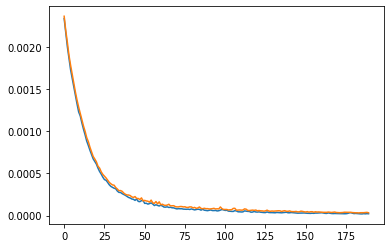

In [12]:
plt.plot(train_loss_history[10:])
plt.plot(test_loss_history[10:])

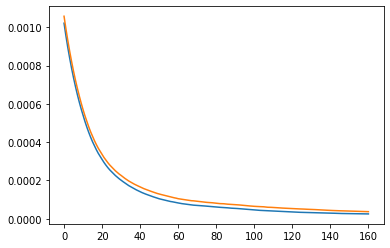

In [13]:
avg_loss_train = moving_average(train_loss_history)
avg_loss_test = moving_average(test_loss_history)
plt.plot(avg_loss_train[10:])
plt.plot(avg_loss_test[10:])

In [14]:
pred = neural_net.forward(X_validation)
pred = pred.data.cpu().numpy()
y_val = Y_validation.data.cpu().numpy()
print('Predicted\t\t\t\tReal value\t\t\t\tDifference')

sum_dn_sq = 0.0
sum_dt_sq = 0.0
sum_e_sq = 0.0
sum_dn = 0.0
sum_dt = 0.0
sum_e = 0.0
sum_dn_real = 0.0
sum_dt_real = 0.0
sum_e_real = 0.0

for i in range(300):
    # dt
    pred[i][1] /= 2.5
    y_val[i][1] /= 2.5
    
    # e
    pred[i][2] /= 6.3
    y_val[i][2] /= 6.3
    
    dif = abs(pred[i]-y_val[i])
    print(pred[i],'\t\t',y_val[i],'\t\t',dif)
    
    sum_dn_sq += dif[0]**2
    sum_dt_sq += dif[1]**2
    sum_e_sq += dif[2]**2
    sum_dn += dif[0]
    sum_dt += dif[1]
    sum_e += dif[2]
    
    sum_dn_real += y_val[i][0]
    sum_dt_real += y_val[i][1]
    sum_e_real += y_val[i][2]
    
mean_dn = sum_dn/300
mean_dt = sum_dt/300
mean_e = sum_e/300
mean_dn_sq = sum_dn_sq/300
mean_dt_sq = sum_dt_sq/300
mean_e_sq = sum_e_sq/300
relative_dn = sum_dn/sum_dn_real
relative_dt = sum_dt/sum_dt_real
relative_e = sum_e/sum_e_real

Predicted				Real value				Difference
[0.5406595  0.18933672 0.08586772] 		 [0.5451904  0.19211987 0.08627383] 		 [0.00453091 0.00278315 0.00040611]
[0.05355393 0.00647857 0.00891382] 		 [0.05383059 0.00443677 0.00851844] 		 [0.00027666 0.0020418  0.00039538]
[0.42823744 0.14876524 0.06780343] 		 [0.42672378 0.15037337 0.06752703] 		 [0.00151366 0.00160813 0.00027639]
[0.30047378 0.10416651 0.04716933] 		 [0.30108565 0.1060997  0.04764539] 		 [0.00061187 0.00193319 0.00047607]
[0.30874524 0.10950376 0.04927502] 		 [0.3100331  0.10925269 0.04906129] 		 [0.00128788 0.00025107 0.00021373]
[0.33697405 0.11882611 0.0530065 ] 		 [0.33845624 0.11926874 0.05355912] 		 [0.00148219 0.00044263 0.00055262]
[0.46152312 0.16295002 0.07337711] 		 [0.46419707 0.16357858 0.07345701] 		 [2.6739538e-03 6.2856078e-04 7.9900026e-05]
[0.39268097 0.1384768  0.06222966] 		 [0.3919015  0.13810232 0.06201658] 		 [0.00077948 0.00037448 0.00021309]
[0.02786858 0.03473071 0.00437589] 		 [0.03162003 0.03651958 0.00

[0.2693402  0.09524623 0.04282808] 		 [0.27046022 0.09530758 0.04279906] 		 [1.1200309e-03 6.1348081e-05 2.9016286e-05]
[0.4802957  0.16739091 0.07531383] 		 [0.4808782  0.16945687 0.07609672] 		 [0.00058252 0.00206596 0.00078289]
[0.5873462  0.20350829 0.09231842] 		 [0.5806017  0.20459847 0.0918775 ] 		 [0.0067445  0.00109018 0.00044092]
[0.48309466 0.16884163 0.07589786] 		 [0.4845064  0.17073539 0.07667086] 		 [0.00141174 0.00189376 0.000773  ]
[0.11797586 0.04195834 0.01925035] 		 [0.12241832 0.04313904 0.01937213] 		 [0.00444246 0.0011807  0.00012177]
[0.5119908  0.17995502 0.0813013 ] 		 [0.51466477 0.18136293 0.08144329] 		 [0.00267398 0.00140791 0.00014199]
[0.32645032 0.11277857 0.05099501] 		 [0.32684398 0.11517668 0.05172153] 		 [0.00039366 0.00239811 0.00072652]
[0.25264725 0.0901527  0.04007564] 		 [0.2538036  0.08943795 0.04016323] 		 [1.1563599e-03 7.1474165e-04 8.7596476e-05]
[0.30537036 0.10730897 0.0482876 ] 		 [0.3056062  0.10769268 0.04836075] 		 [2.3582578e-04 3.8

In [15]:
print('Dn MAE: ', mean_dn)
print('Dt MAE: ', mean_dt)
print('e MAE: ', mean_e)
print('Dn MSE: ', math.sqrt(mean_dn_sq))
print('Dt MSE: ', math.sqrt(mean_dt_sq))
print('e MSE: ', math.sqrt(mean_e_sq))
print('Dn Relative: ', relative_dn)
print('Dt Relative: ', relative_dt)
print('e Relative: ', relative_e)

Dn MAE:  0.0034022231632843615
Dt MAE:  0.001763158182729967
e MAE:  0.0005068319147297492
Dn MSE:  0.005243843393760936
Dt MSE:  0.0027056703991069626
e MSE:  0.0008459820204618162
Dn Relative:  0.010695652128509214
Dt Relative:  0.013779044502728727
e Relative:  0.010068796734868345


In [17]:
# проверим как предсказанные значения связаны с аналитической формулой
Vs = 2750
Vp = 5000
g = (Vs**2)/(Vp**2)
print('e (crack density)\tDn formula\tPredicted value\tDifference')
sum_dif = 0.0
for i in range(300):
    e_pred = pred[i][2]
    formula = 4*e_pred/(3*g*(1-g))
    dn_pred = pred[i][0]
    dif = abs(dn_pred-formula)
    sum_dif += dif
    print(e_pred,'\t',formula,'\t',dn_pred,'\t',dif)

e (crack density)	Dn formula	Predicted value	Difference
0.08586772 	 0.5426240847553018 	 0.5406595 	 0.001964597507834731
0.008913815 	 0.05632909361226667 	 0.053553928 	 0.002775165922475946
0.06780343 	 0.4284703698696841 	 0.42823744 	 0.00023293166777982321
0.047169328 	 0.29807725101431287 	 0.30047378 	 0.0023965284256132757
0.04927502 	 0.3113837465156138 	 0.30874524 	 0.0026385113109171354
0.053006496 	 0.3349640848314654 	 0.33697405 	 0.002009969743501039
0.07337711 	 0.46369215558299526 	 0.46152312 	 0.002169039948077045
0.062229663 	 0.39324806624917386 	 0.39268097 	 0.0005670934346139189
0.0043758918 	 0.027652583769213677 	 0.02786858 	 0.00021599630390453303
0.08178739 	 0.5168392744465192 	 0.5142819 	 0.0025573459072431026
0.04386704 	 0.2772090985351558 	 0.27909568 	 0.0018865809864048733
0.023237115 	 0.14684235763508374 	 0.14381766 	 0.003024694442334719
0.09626473 	 0.6083259332794096 	 0.6079879 	 0.00033805257262253807
0.029622326 	 0.18719243689255807 	 0

In [18]:
print('Mean difference between predicted value and formula for Dn: ', sum_dif/300)
print('Relative difference between predicted value and formula for Dn: ', sum_dif/abs(sum_dn_real))

Mean difference between predicted value and formula for Dn:  0.0030575462222475897
Relative difference between predicted value and formula for Dn:  0.0096120828030658


In [21]:
print('e (crack density)\tDt formula\tPredicted value\tDifference')
sum_dif = 0.0
for i in range(300):
    e_pred = pred[i][2]
    formula = 16*e_pred/(3*(3-2*g))
    dt_pred = pred[i][1]
    dif = abs(dt_pred-formula)
    sum_dif += dif
    print(e_pred,'\t',formula,'\t',dt_pred,'\t',dif)

e (crack density)	Dt formula	Predicted value	Difference
0.08586772 	 0.19121551646403162 	 0.18933672 	 0.0018787993352779586
0.008913815 	 0.01984983164150846 	 0.006478572 	 0.013371259842856049
0.06780343 	 0.15098884359530965 	 0.14876524 	 0.002223607456012161
0.047169328 	 0.10503956072016897 	 0.10416651 	 0.0008730529992217045
0.04927502 	 0.10972864194802301 	 0.10950376 	 0.00022488101414697148
0.053006496 	 0.11803812672051606 	 0.118826106 	 0.0007879794701654008
0.07337711 	 0.16340066263388658 	 0.16295002 	 0.00045063862513566866
0.062229663 	 0.13857684205120938 	 0.1384768 	 0.00010003815239803537
0.0043758918 	 0.009744504963099003 	 0.03473071 	 0.02498620512610769
0.08178739 	 0.1821291969315244 	 0.18107894 	 0.0010502563015653
0.04386704 	 0.09768582419048354 	 0.097120896 	 0.0005649282086949009
0.023237115 	 0.05174583665347381 	 0.050883807 	 0.0008620294115571567
0.09626473 	 0.21436821692671804 	 0.21101126 	 0.00335695617880849
0.029622326 	 0.06596481708826

In [22]:
print('Mean difference between predicted value and formula for Dt: ', sum_dif/300)
print('Relative difference between predicted value and formula for Dt: ', sum_dif/abs(sum_dt_real))

Mean difference between predicted value and formula for Dt:  0.01689512955979764
Relative difference between predicted value and formula for Dt:  0.13203508588399476
